# Algorithms Examples on Yelp Data

This notebook demonstrates some simple algorithm applications with the yelp dataset (https://www.yelp.com/dataset) that could be incorporated into a demo or used as examples.

The data were imported to Neo4J following this instructions in Neo4J's graph algorithms documentation: https://neo4j.com/docs/graph-algorithms/current/yelp-example/

Code is designed to be run in a conda environment to avoid dependency conflicts - I've exported mine as neo4j_environment.yml and shared it in the repo.

In [1]:
from py2neo import Graph
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## A little bit of architecture engineering

To match the work the Morpheus team has already done for their demo, and to break the data into a manageable size for running algorithms locally, I'm going to limit my work to businesses in Phoenix. I'm going to add "reviewed_by" relationships between Businesses and Users, to avoid dealing with the review entity type. Since I don't have support for multi-graphs, and I might like to do some time series analysis, I will make separate edges for separate years - 2015, 2016, and 2017

In [1]:
# set up the py2neo driver to run queries from python
from py2neo import Graph
uri = 'bolt://localhost:7687'
yelpGraph=Graph(uri, auth=("neo4j","password"))

In [ ]:
date_range=[2010,2011,2012,2013,2014,2015,2016,2017]
for date in date_range:
    query='''    
        MATCH (business:Business)-[review_of:REVIEWS]-(review:Review)-[wrote:WROTE]-(user:User)
        WHERE review.date contains "{0}" and business.city contains 'Phoenix'
        WITH business, user, review
        MERGE (business)-[reviewed_by:REVIEWED_BY_{0}]-(user)
        SET reviewed_by.date = review.date, reviewed_by.stars = review.stars
    '''.format(date)
    # you'd probably want to run more iterations but I don't want my laptop to catch on fire
    yelpGraph.run(query)


let's start with a quick visualization just to see if the number of users, reviews, and businesses have been stable across the three years

In [29]:
query='''
    Match (business:Business)-[r]-(user:User)
    WHERE type(r) = 'REVIEWED_BY_2017' or type(r)='REVIEWED_BY_2016' or type(r)='REVIEWED_BY_2015' or type(r)='REVIEWED_BY_2014'or type(r)='REVIEWED_BY_2013'or type(r)='REVIEWED_BY_2012'or type(r)='REVIEWED_BY_2011'or type(r)='REVIEWED_BY_2010'
    return type(r) as review_year, count(distinct r) as num_reviews
''' 

count_reviews_by_year=yelpGraph.run(query).to_data_frame()

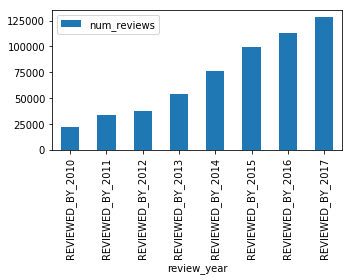

In [31]:
count_reviews_by_year.sort_values(by='review_year').plot(kind='bar', x='review_year', y='num_reviews',figsize=(5,4))
plt.tight_layout()

In [ ]:
query='''
    Match (business:Business)-[r]-(user:User)
    WHERE type(r) = 'REVIEWED_BY_2017' or type(r)='REVIEWED_BY_2016' or type(r)='REVIEWED_BY_2015' or type(r)='REVIEWED_BY_2014'or type(r)='REVIEWED_BY_2013'or type(r)='REVIEWED_BY_2012'or type(r)='REVIEWED_BY_2011'or type(r)='REVIEWED_BY_2010'
    return type(r) as year, count(distinct user) as num_users
'''

count_users_by_year=yelpGraph.run(query).to_data_frame()
count_users_by_year.sort_values(by='year').plot(kind='bar', x='year', y='num_users',figsize=(5,4))
plt.tight_layout()

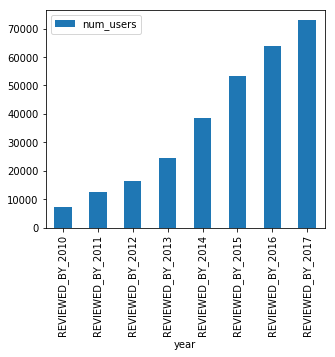

In [25]:
count_users_by_year.sort_values(by='year').plot(kind='bar', x='year', y='num_users',figsize=(5,4))

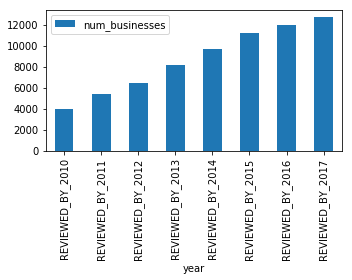

In [20]:
query='''
    Match (business:Business)-[r]-(user:User)
    WHERE type(r) = 'REVIEWED_BY_2015' or type(r)='REVIEWED_BY_2016' or type(r)='REVIEWED_BY_2017' or type(r)='REVIEWED_BY_2014'or type(r)='REVIEWED_BY_2013'or type(r)='REVIEWED_BY_2012'or type(r)='REVIEWED_BY_2011'or type(r)='REVIEWED_BY_2010'
    return type(r) as year, count(distinct business) as num_businesses order by year
'''

count_bus_by_year=yelpGraph.run(query).to_data_frame()
count_bus_by_year.plot(kind='bar', x='year', y='num_businesses',figsize=(5,4))
plt.tight_layout()

## Page Ranking

A popular algorithm on a social graph is PageRank - it basically tells you how important a given node is in a network. The part of the graph we're interested in (the (business)-[reviewed_by]-(user) part) is bipartite, meaning that there are two node classes with links between them, but no links within them (I delete the (user)-[friend_of]-(user) relationship to enforce this). To make page rank work, I'll calculate two page ranks - one for users, one for businesses - on a projection of the graph.

In [9]:
# delete the friend edges
query='''
MATCH ()-[r:FRIEND]-()
DELETE r
'''

yelpGraph.run(query)

In [41]:
date_range=[2010,2011,2012,2013,2014,2015,2016,2017]
for date in date_range:
    query='''
        CALL algo.pageRank(
        'MATCH (u:User) where exists ( (u)-[:REVIEWED_BY_{0}]-()) RETURN id(u) as id',
        'MATCH (u1:User)-[r:REVIEWED_BY_{0}]-(b:Business)-[r2:REVIEWED_BY_{0}]-(u2:User) RETURN id(u1) as source, id(u2) as target',
        {{graph:'cypher',iterations:5, write: true,writeProperty:"page_rank_{0}"}}) 
        YIELD nodes, iterations, loadMillis, computeMillis, writeMillis, dampingFactor, write, writeProperty
    '''.format(date)
    # you'd probably want to run more iterations but I don't want my laptop to catch on fire
    yelpGraph.run(query)


In [78]:
# extract average page rank for elite and non elite users for each year
date_range=[2010,2011,2012,2013,2014,2015,2016,2017]
elite_result_list=[]
for date in date_range:
    query='''
        MATCH (u:User)
        WHERE u.elite contains '{0}' AND exists(u.page_rank_{0})
        RETURN avg(u.page_rank_{0})
    '''.format(date)
    pagerank=yelpGraph.run(query).to_series()
    elite_result_list.append(pagerank[0])

In [79]:
# extract average page rank for elite and non elite users for each year
date_range=[2010,2011,2012,2013,2014,2015,2016,2017]
not_elite_result_list=[]
for date in date_range:
    query='''
        MATCH (u:User)
        WHERE NOT u.elite contains '{0}' AND exists(u.page_rank_{0})
        RETURN avg(u.page_rank_{0})
    '''.format(date)
    pagerank=yelpGraph.run(query).to_series()
    not_elite_result_list.append(pagerank[0])

In [80]:
# do elites have higher page ranks than non-elites?
from scipy import stats
stats.ttest_rel(elite_result_list,not_elite_result_list)

Ttest_relResult(statistic=5.560056633073341, pvalue=0.0008508638724438304)

**So we've show that elites have a significantly higher average page rank than non-elites (p < 0.001)**

## Where do the users live?

We can use the graph data to infer a user's location based on the locations of businesses that they've reviewed. We can assume that the coordinates are generally close to eachother (since we're only looking at Phoenix), so we can treat the earth as locally flat, and find the centroid by treating the latitude and longitude as planar coordinates - and take the average over the set.

In [81]:
query='''
    Match (u:User)-[r]-(b:Business)
    WITH u, avg(b.latitude) as centroid_latitude, avg(b.longitude) as centroid_longitude
    SET u.inferred_lat=centroid_latitude, u.inferred_long=centroid_longitude
'''
yelpGraph.run(query)

I'm not going to do anything with this now, but this could be used as a feature in a model or for recommendations of nearby, highly rated businesses.

## Clusters for Recommendations

We can use customer similarity to make recommendations about businesses, but on a large graph, it may not be advisable to calculate the full nxn similarity matrix. Instead, we'll use Louvain to identify clusters of users, and then within one cluster, take an example user, find their most similar counterpart, and identify a highly rated business that they haven't tried yet.

### Assign Louvain Clusters

As with the page rank example, the louvain clustering algorithm (as implemented) is intended for monopartite graphs. Although it is possible to modify the algorithm to handle bipartite graphs appropriately (eg. https://louvain-igraph.readthedocs.io/en/latest/multiplex.html) the graph algorithm

In [3]:
query="""
call algo.louvain(
    'MATCH (u:User) return id(u) as id',
    'MATCH (u1:User)<-[r:REVIEWED_BY_2017]-(b:Business)-[r2:REVIEWED_BY_2017]->(u2:User) WHERE NOT id(u1)=id(u2) return id(u1) as source, id(u2) as target, count(distinct b) as weight',
    {graph:'cypher', weightProperty:'weight', write:true, writeProperty:'community_label'})
    YIELD nodes, communityCount, iterations, loadMillis, computeMillis, writeMillis;
"""
result=yelpGraph.run(query).data()

In [2]:
#lets check the communities and first plot their size distribution
query='''
    MATCH (u:User) 
    WHERE EXISTS(u.community_label)
    RETURN DISTINCT u.community_label as community, count(u) as community_freq 
'''
result=yelpGraph.run(query).to_data_frame()

In [3]:
result.head()

,community,community_freq
0,0,1
1,1,1
2,2,1
3,3,1
4,4,5


In [6]:
result.dtypes

community         int64
community_freq    int64
dtype: object

In [14]:
#now let's choose a reasonably size community for recommendations
query='''
    MATCH (u:User) 
    WHERE EXISTS(u.community_label)
    WITH DISTINCT u.community_label as community, count(u) as freq 
    WHERE freq>10
    RETURN community, freq
'''
result=yelpGraph.run(query).to_data_frame()
result

,community,freq
0,11,5398
1,32,4589
2,51,9922
3,56,2365
4,60,836
5,74,2034
6,78,707
7,82,1202
8,91,1125
9,104,8016


In [ ]:
# for our chosen cluster, let's find pairs of users who are fairly similar